# MMA 830 Project
#### Team Oliers

## Load packages

In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np
import holidays
import statsmodels.formula.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
import warnings

warnings.filterwarnings("ignore")
from IPython import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Load data

In [2]:
df_cal = pd.read_csv("calendar.csv")
df_listing = pd.read_csv("listings.csv")

time: 11.9 s


## Check the communities in the dataset

In [3]:
communities_list = df_listing.neighbourhood_cleansed.unique()
communities_list

array(['Little Portugal', 'Waterfront Communities-The Island', 'Annex',
       'Briar Hill-Belgravia', 'Greenwood-Coxwell', 'South Parkdale',
       'Oakridge', 'Wexford/Maryvale', 'Rosedale-Moore Park',
       'Church-Yonge Corridor', 'Niagara', 'Moss Park',
       'Palmerston-Little Italy', 'Dufferin Grove', 'South Riverdale',
       'High Park North', 'Danforth East York', 'Yonge-Eglinton',
       'High Park-Swansea', 'Downsview-Roding-CFB', 'Woburn',
       'Humewood-Cedarvale', 'The Beaches', 'Junction Area',
       'Stonegate-Queensway', 'North Riverdale', 'North St.James Town',
       'Bay Street Corridor', 'Dovercourt-Wallace Emerson-Junction',
       'Caledonia-Fairbank', 'Roncesvalles', 'Broadview North',
       'Yonge-St.Clair', 'Kensington-Chinatown', 'Mount Pleasant East',
       'Blake-Jones', 'Willowdale East', 'Danforth', 'Regent Park',
       'Flemingdon Park', 'Mount Pleasant West', 'East End-Danforth',
       'Woodbine Corridor', 'Brookhaven-Amesbury', 'Oakwood Villa

time: 20 ms


# Define a function to get the optimal price and maximize the revenue

In [12]:
def get_best_discount(
    target_c=["Dovercourt-Wallace Emerson-Junction"],
    neighboor_c=["Dufferin Grove", "Junction Area"],
):
    """
    The function can help to get the optimal price and maximize the revenue
    
    Target can only have one community.
    neighboor can have one or more communities.
    
    """
    ca_holiday = holidays.CountryHoliday("CA", prov="ON")

    df_selected = df_listing[
        df_listing.neighbourhood_cleansed.isin(target_c + neighboor_c)
    ]
    list_id = df_selected.id.unique()

    df_cal_selected = df_cal[df_cal.listing_id.isin(list_id)]
    df_cal_selected = df_cal_selected.merge(
        df_selected[["id", "neighbourhood_cleansed"]],
        left_on="listing_id",
        right_on="id",
        how="left",
    )

    df_cal_selected["adjusted_price"] = df_cal_selected["adjusted_price"].str[:-3]
    df_cal_selected["adjusted_price"] = df_cal_selected["adjusted_price"].str.replace(
        ",", ""
    )
    df_cal_selected["adjusted_price"] = df_cal_selected["adjusted_price"].str.replace(
        "$", ""
    )
    df_cal_selected["adjusted_price"] = df_cal_selected["adjusted_price"].astype(int)

    df_grouped = (
        df_cal_selected.groupby(["neighbourhood_cleansed", "date"])
        .agg({"adjusted_price": np.sum, "id": pd.Series.nunique})
        .reset_index()
    )

    df_cal_selected_f = df_cal_selected[df_cal_selected.available == "f"]
    df_grouped_f = (
        df_cal_selected_f.groupby(["neighbourhood_cleansed", "date"])
        .agg({"available": len})
        .reset_index()
    )

    df_grouped = df_grouped.merge(
        df_grouped_f, on=["neighbourhood_cleansed", "date"], how="left"
    )

    df_grouped["adjusted_price"] = df_grouped["adjusted_price"] / df_grouped["id"]
    df_grouped.columns = [
        "neighbourhood",
        "date",
        "sale_price",
        "listing_number",
        "sales",
    ]

    df_grouped["date"] = pd.to_datetime(df_grouped["date"])
    base_line = df_grouped.date.min()
    df_grouped["trend"] = (df_grouped["date"] - base_line).dt.days / 365.25

    # df_grouped["weekly_sin"] = np.sin(df_grouped.trend / 7 * 2 * np.pi)
    # df_grouped["weekly_cos"] = np.cos(df_grouped.trend / 7 * 2 * np.pi)
    # df_grouped["monthly_sin"] = np.sin(df_grouped.trend / 30 * 2 * np.pi)
    # df_grouped["monthly_cos"] = np.cos(df_grouped.trend / 30 * 2 * np.pi)
    # df_grouped["quarterly_sin"] = np.sin(df_grouped.trend / 91.25 * 2 * np.pi)
    # df_grouped["quarterly_cos"] = np.cos(df_grouped.trend / 91.25 * 2 * np.pi)
    # df_grouped["yearly_sin"] = np.sin(df_grouped.trend / 365 * 2 * np.pi)
    # df_grouped["yearly_cos"] = np.cos(df_grouped.trend / 365 * 2 * np.pi)

    df_grouped["weekday"] = df_grouped["date"].dt.dayofweek
    df_grouped["weekday"] = df_grouped["weekday"].astype(str)
    df_grouped = pd.get_dummies(df_grouped, columns=["weekday"])
    df_grouped["date"] = df_grouped["date"].astype(str)

    df_grouped["holiday"] = df_grouped["date"].apply(
        lambda x: 1 if x in ca_holiday else 0
    )
    df_grouped = df_grouped[df_grouped.listing_number >= 10]
    df_list = [
        df_grouped[df_grouped.neighbourhood.isin(target_c)],
        df_grouped[df_grouped.neighbourhood.isin(neighboor_c)],
    ]

    df_list[1]["total_rev"] = df_list[1].sale_price * df_list[1].listing_number
    neigh_df = df_list[1].groupby("date").agg({"total_rev": sum, "listing_number": sum})

    neigh_df["neighboor_price"] = neigh_df.total_rev / neigh_df.listing_number

    neigh_df = neigh_df.reset_index()

    target_df = df_list[0].merge(
        neigh_df[["date", "neighboor_price"]], on="date", how="left"
    )

    formula_part = ""
    for i in list(target_df.iloc[:, 5:].columns):
        formula_part = formula_part + " + " + i

    formula = "sales ~ " + formula_part + " +holiday+sale_price "

    results = sm.ols(formula, target_df).fit()
    pred = results.predict(target_df)
    target_df["pred"] = pred

    target_df["sale_price_copy"] = target_df.sale_price

    def profit(discount):
        target_df.sale_price = target_df.sale_price_copy - discount
        target_df["pred"] = results.predict(target_df)
        target_df["demond_pred"] = np.where(
            target_df.listing_number >= target_df.pred,
            target_df.pred,
            target_df.listing_number,
        )
        return -np.sum(target_df.sale_price * target_df["demond_pred"])

    def con(discount):
        return np.sum((discount > 0)) - 1

    discount = 0
    opt = minimize(
        profit, discount, method="BFGS", constraints={"type": "eq", "fun": con}
    )
    target_df["rev_pred"] = target_df["pred"] * target_df["sale_price"]
    target_df["rev_orig"] = target_df["sales"] * target_df["sale_price_copy"]
    target_df["date"] = pd.to_datetime(target_df["date"])
    plt.figure(figsize=(35, 4))
    ax = plt.subplot(1, 1, 1)
    p1 = ax.plot(target_df.date, target_df[["rev_pred", "rev_orig"]], alpha=0.6)

    plt.legend(
        p1[:2],
        ["Optimal Revenue", "Original Revenue"],
        frameon=False,
        loc="lower center",
        ncol=2,
    )
    # plt.xticks(rotation=90)
    plt.title("Revenue comparison")

    print(opt.x)
    return

time: 132 ms


## Test the function

### Test on "Dovercourt-Wallace Emerson-Junction"

[19.63999801]


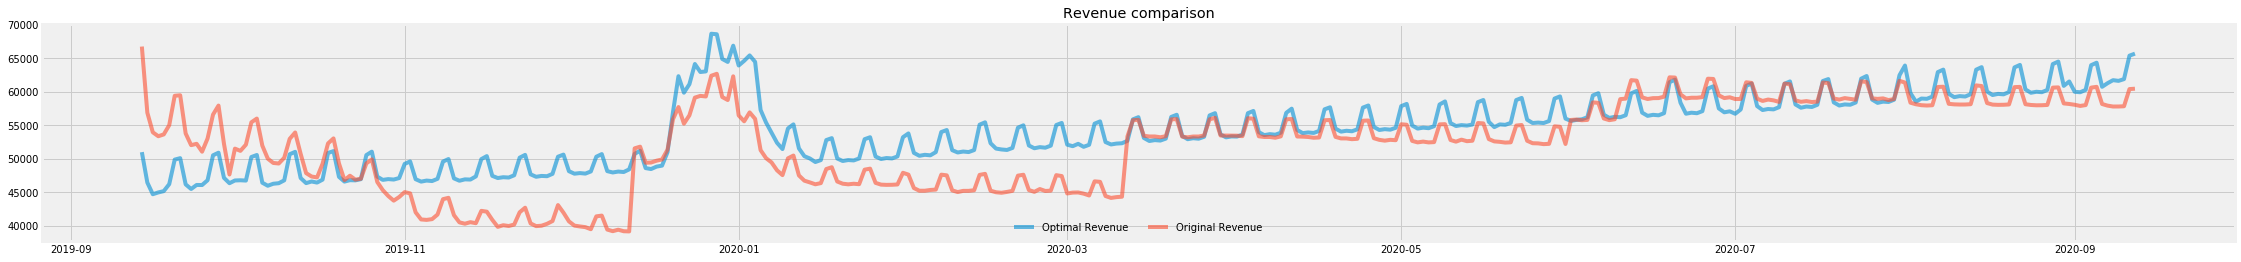

time: 3.02 s


In [13]:
get_best_discount(
    target_c=["Dovercourt-Wallace Emerson-Junction"],
    neighboor_c=["Dufferin Grove", "Junction Area"],
)

### Test on "Oakwood Village"

[23.9175815]


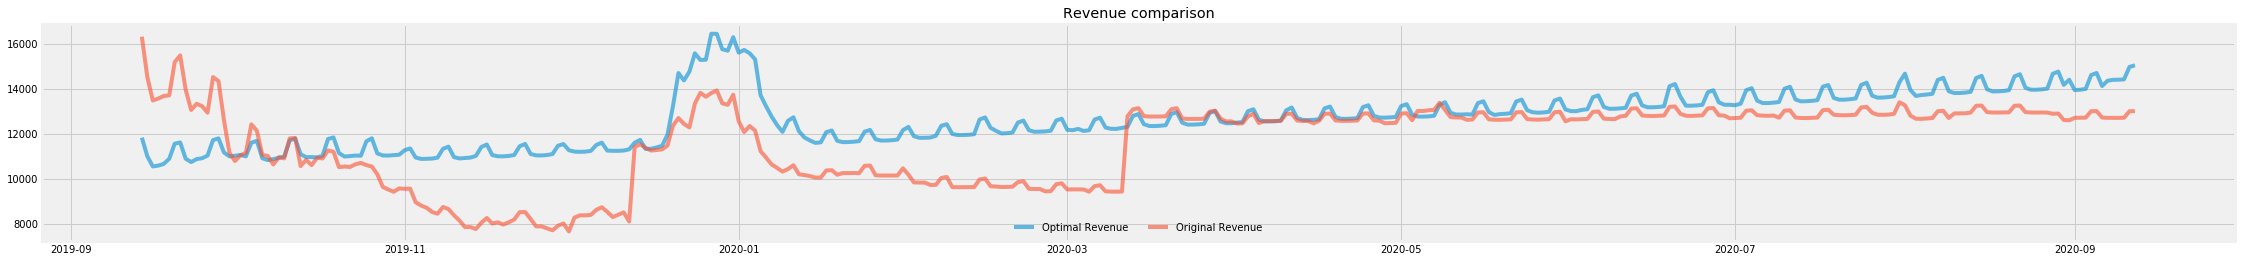

time: 2.85 s


In [14]:
get_best_discount(
    target_c=["Oakwood Village"], neighboor_c=["Dufferin Grove", "Junction Area"]
)